In [118]:
% matplotlib inline

In [155]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import linear_model
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# Social media usage reveals how small businesses recover after natural disasters in urban areas

#### Robert Eyre, Flavia De Luca, Filippo Simini

The challenge of nowcasting and forecasting the effect of natural disasters (e.g. earthquakes, floods, hurricanes) on assets,
people and society is of primary importance for assessing the ability of such systems to recover from extreme events. Traditional
disaster recovery estimates, such as surveys and interviews, are usually costly, time consuming and do not scale. Here we
present a methodology to indirectly estimate the post-emergency recovery status (‘downtime’) of small businesses in urban
areas looking at their online posting activity on social media. Analysing the time series of posts before and after an event, we
quantify the downtime of small businesses for three natural disasters occurred in Nepal, Puerto Rico and Mexico. A convenient
and reliable method for nowcasting the post-emergency recovery status of economic activities could help local governments
and decision makers to better target their interventions and distribute the available resources more effectively.

# Load data

Load anonymous post data (businesses_id's have been randomised, posting day has been altered by +/- 3 days, and hour, minutes, seconds have been removed).

In [224]:
# Gorkha Earthquake
event_date = pd.to_datetime('2015-04-25')
posts = pd.read_csv('./data/post_data_k.csv.zip', parse_dates=['date'])

# # Hurricane Maria
# event_date = pd.to_datetime("2017-09-20")
# posts = pd.read_csv('./data/post_data_pr.csv.zip', parse_dates=['date'])

# # Chiapas Earthquake
# event_date = pd.to_datetime('2017-09-07')
# posts = pd.read_csv('./data/post_data_c.csv.zip', parse_dates=['date'])

In [225]:
posts = posts[posts.date >= '2013-01-01']
posts = posts[posts.date < '2018-05-01']

In [226]:
posts.head()

,date,b_id
0,2018-01-15,2158
1,2018-01-02,2158
2,2017-12-14,2158
3,2017-12-15,2158
4,2017-11-14,2158


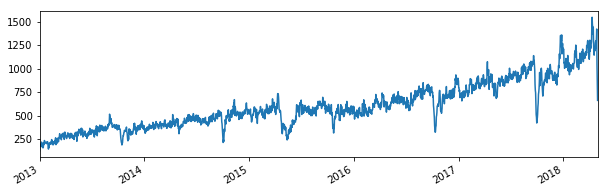

In [227]:
posts.date.value_counts().plot(figsize=[10, 3])

# Step 1: Probability integral transform

In [228]:
# Parameter used to detect in realtime
realtime_days = 3

In [229]:
def PIT(posts):

    # Data range for posts that we are looking at.
    start, end = (
        posts["date"].min(),
        posts["date"].max() + pd.Timedelta("{} day".format(realtime_days)),
    )
    dr = pd.date_range(start, end, freq="D")

    # Create list to store PIT vals.
    pit_array = []

    # Store for estimate of active businesses.
    num_active = pd.Series(0, index=dr)

    # Look at each business seperately.
    businesses = posts.groupby("b_id")

    for i, (_id, b) in enumerate(businesses):

        if int(len(businesses) / 100) != 0:
            if i % int(len(businesses) / 100) == 0:
                print(
                    "\r", "  Progress: ", np.ceil(100 * i / len(businesses)), end="%",
                )

        # Get number of posts made each day by business b
        b_posts = b["date"].value_counts()

        # Reindex so we count the days with no posts
        b_start, b_end = (
            b_posts.index.min(),
            b_posts.index.max() + pd.Timedelta("{} day".format(realtime_days)),
        )
        idx = pd.date_range(b_start, b_end)
        b_posts = b_posts.reindex(idx, fill_value=0)

        # Update the estimate for the number of active businesses.
        # We just store the start and end dates, we can then call
        # .cumsum later on to get the running number of active businesses.
        num_active.at[b_start] += 1
        if b_end + pd.Timedelta("{} day".format(realtime_days)) <= end:
            num_active.at[b_end + pd.Timedelta("{} day".format(realtime_days))] -= 1

        # Split the business into multiple parts
        # We assume that a business changes
        # its habits over time.
        chunks = enumerate(np.array_split(b_posts, max(1, len(b_posts) / 365),))

        # For each chunk, compute the PIT, add to the list.
        for k, chunk in chunks:
            ecdf = ECDF(chunk)
            pit_vals = (ecdf(chunk) + ecdf(chunk - 1)) / 2
            pit_array.append(pd.Series(pit_vals, index=chunk.index,))

    # Create aggregate dataframe.
    pit_array = pd.concat(pit_array)
    aggregate_df = pit_array.groupby(pit_array.index).sum()[:-realtime_days]

    # Get number of active businesses on a given day.
    num_active = num_active.cumsum()[:-realtime_days]
    return aggregate_df, num_active

   Progress:  100.0%

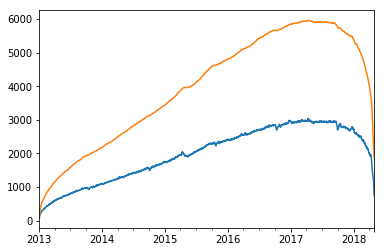

In [230]:
aggregate_df, num_active = PIT(posts)

aggregate_df.plot()
num_active.plot()

# Step 2: Apply Irwin Hall

In [231]:
def IH(aggregate_df, num_active, date=None):
    def remove_linear_trend(detr_df0):

        detr_df0 = detr_df0.dropna()

        y = detr_df0.loc[:date].rolling(14).mean().dropna().values
        x = np.arange(len(y))

        model = linear_model.LinearRegression(fit_intercept=True)
        model.fit([[xx] for xx in x[:]], y[:])

        yf = model.coef_ * np.arange(len(detr_df0.values)) + model.intercept_

        detr_df0_m = pd.Series(detr_df0.values - yf, index=detr_df0.index)

        return detr_df0_m

    IH_m0 = aggregate_df - (num_active / 2)

    IH_m0_v1 = IH_m0 / np.sqrt(num_active / 12)

    IH_m0_v1 = remove_linear_trend(IH_m0_v1)

    IH_m0_vu = IH_m0_v1 / (IH_m0_v1.std())

    ih = lambda row: stats.norm.cdf(row, loc=0.0, scale=1.0)

    ih = IH_m0_vu.apply(ih)

    return ih

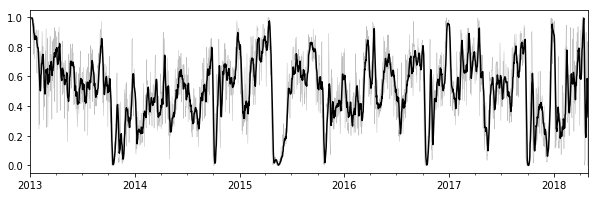

In [232]:
fig, ax = plt.subplots()

ih = IH(aggregate_df, num_active)

ih.plot(figsize=[10, 3], c = 'k', lw = 0.5, alpha = 0.25)
ih.rolling(7).mean().plot(figsize=[10, 3], c = 'k')

# Step 3: Event detection

In [233]:
def find_threshold(ih, ax=None):

    ih = ih.rolling(7).mean()

    prec = 500
    min_thresh = 0
    max_thresh = 1

    # Calculate all thresholds at once.
    b = pd.concat([ih] * prec, axis=1)

    # Find where IH is less than each possible threshold value.
    s = b < np.linspace(min_thresh, max_thresh, prec)

    # Find number of events under threshold.
    events = s ^ s.shift(1)
    events = (events.sum(axis=0) / 2).apply(int)

    # Avoids setting the threshold < 0.1
    events.iat[0] = events.iloc[0 : int(prec / 10)].max()
    events.index = np.linspace(min_thresh, max_thresh, prec)

    # Find point that gives maximal angle
    k = np.arctan((events - events.iloc[0]) / (events.index - events.index[0]))

    # Fit line from [0,0] to [idxmax, max], find maximal difference from this line and set as elbow point.
    p = np.poly1d([events.loc[k.idxmax()] / k.idxmax(), 0])
    t = (p(events[: k.idxmax()].index) - events[: k.idxmax()].values).argmax()
    tx = events.index[t]

    # Plot number of events vs threshold
    if ax:
        events.iat[0] = 0
        events.plot(label="$y = f(T)$", c="k", ax=ax)
        ax.scatter(k.idxmax(), events.loc[k.idxmax()])
        ax.plot(
            events[: events.idxmax()].index,
            p(events[: events.idxmax()].index),
            label="$y = \Theta T$",
            ls=":",
            c="k",
        )
        ax.plot(
            [events.index[t], events.index[t]],
            [events.iloc[t], p(events.index[t])],
            ls="--",
            c="r",
            label="$\max[f(\Theta) - f(T)]$",
        )
        ax.legend(loc=4)

    return tx, events

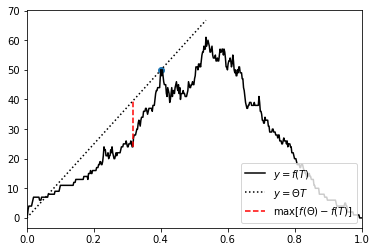

In [234]:
fig, ax = plt.subplots()

threshold, events_per_threshold = find_threshold(ih, ax=ax)

In [235]:
def get_event(ih, threshold, date, all_events=False):

    ih = ih.rolling(7).mean()

    df = (ih < threshold).apply(int)
    lst = [g for (_, g) in df.groupby((df.diff() != 0).cumsum()) if sum(g) > 0]

    if all_events:
        return list(zip(lst, map(len, lst)))

    for e in lst:
        if date in e or (
            pd.to_datetime(date) < e.index.max()
            and pd.to_datetime(date) > e.index.min() - pd.Timedelta("7 days")
        ):
            return e, len(e)

    return 0, 0

In [236]:
events = get_event(ih, threshold, event_date, all_events=True)

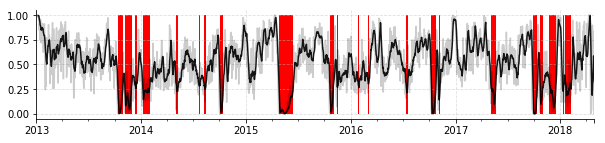

In [237]:
fig, ax = plt.subplots(figsize=[10, 2])

ih.plot(c="k", alpha=0.2)
ih.rolling(7).mean().plot(c="k", alpha=0.9)

for e in events:
    plt.fill_between(e[0].index.values, 0, 1, facecolor="r")
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().grid(linestyle="--", color="silver", alpha=0.5)
    plt.gca().tick_params(axis="x", rotation=0)

In [238]:
# Find the downtime event.
downtime_event, downtime_length = get_event(ih, threshold, event_date)

In [239]:
print(downtime_length)

50


# Realtime simulation

We simulate collection in realtime by cropping our data and applying the procedure to just the cropped data. 

   Progress:  100.0%

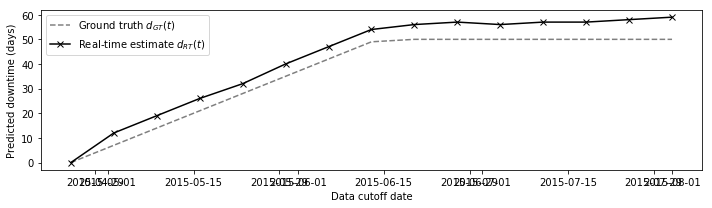

In [240]:
downtimes = []

for _, cutoff in enumerate(
    sorted(pd.date_range(event_date, event_date + pd.Timedelta("100 days"), freq="7D"))
):

    # Apply PIT
    detr, num_act = PIT(posts[posts.date < cutoff])

    # Apply IH
    ih = IH(detr, num_act, event_date)

    # Event detection
    threshold, _ = find_threshold(ih)

    # Get all events
    all_events = get_event(ih, threshold, event_date)

    downtimes.append(
        [cutoff, min((cutoff - event_date).days, downtime_length), all_events[1]]
    )


fig = plt.figure(figsize=[10, 3],)

x, y, z = zip(*downtimes)
plt.gca().plot(x, y, ls="--", c="k", alpha=0.5, label="Ground truth $d_{GT}(t)$")
plt.gca().plot(x, z, marker="x", c="k", label="Real-time estimate $d_{RT}(t)$")
plt.gca().legend()


plt.gca().set_xlabel("Data cutoff date")
plt.gca().set_ylabel("Predicted downtime (days)")


plt.tight_layout()